# Python API's
## John M. Warlop
## UCSD Bootcamp Spring 2018
## Due 3/31/18

In [1]:
# Dependencies
import codecs
import openweather as ow
import matplotlib.pyplot as plt
import csv
import pickle
import pandas as pd
import random
import json
import requests
import logging
import time

WAIT_TIME = 1.2
SAMPLE_SIZE  = 20   #s/b 20 for release
SAMPLE_SIZE2 = 500  #s/b 500 for release
raw_fpath = '../raw_data/worldcitiespop.csv'
pickle_fpath = '../raw_data/cities_sorted_by_lat.pkl'
s_fname = 'api_keys'
api_keys = {}
with open(s_fname) as f:
    api_keys = json.load(f)

skip_load = True #Set false to reload raw file
# Config Logger
LOG_FORMAT = "%(levelname)s %(asctime)s - %(message)s"
logging.basicConfig(filename="r_log.log",level=logging.DEBUG,format=LOG_FORMAT,filemode='w')
logger = logging.getLogger()
# 
def file_kosher(reader):
    fcount = 0
    rcount = 0 
    for row in reader:
        if fcount == 0: #header row
            fcount = len(row) #all rows should have this number of fields
        if fcount == 0 or len(row) != fcount:
            return(0)
        rcount += 1
    return(rcount)

def lat_xover(lat_l):
    c = 0
    for e in lat_l:
        if e[5] > 0:
            return c
        c += 1
    return(0)

def get_random_cities(sorted_l,xover_idx):
    max_lat = sorted_l[-1][5]
    min_lat = sorted_l[0][5]
    lat_delta = abs(max_lat - min_lat)
    north_deg_bins = [i*abs(max_lat/20.0) for i in range(0,21)]
    north_deg_bins[-1] = max_lat
    south_deg_bins = [i*abs(min_lat/20.0)*-1.0 for i in range(0,21)]
    south_deg_bins[-1] = min_lat
    south_deg_bins = south_deg_bins[::-1]
    print(south_deg_bins)
    c = 0
    # Southern Hemisphere
    south_idx_bins = []
    idx1 = 0
    #import pdb;pdb.set_trace()
    for idx0,row in enumerate(sorted_l):
        if idx0 == 0: continue
        if row[5] < south_deg_bins[idx1+1]:
            continue
        if idx1 == len(south_deg_bins): break
        idx1 += 1
        south_idx_bins.append(idx0)
        break

In [ ]:
# Load CSV
if not skip_load:
    error = False
    logger.info("Open pickle: {}".format(raw_fpath))
    with open(raw_fpath,"r",encoding="ISO-8859-1") as f:
        reader = csv.reader(f)
        nrows = file_kosher(reader)
        if not nrows:
            error = True
        reader = f.seek(0) #put back @ head
        c = 0
        reader = csv.reader(f)
        file_l = []
        next(reader,None)
        for row in reader:
            row[5] = float(row[5])
            row[6] = float(row[6])
            trow = tuple(row)
            file_l.append(trow)
            c += 1
        logger.info("Raw file loaded, sorting list")
        ss = sorted(file_l,key = lambda x: (x[5],x[6]))
        pckl_out = open(pickle_fpath,"wb")
        logger.info("Dumping sorted list to pickle to: {}".format(pickle_fpath))
        pickle.dump(ss,pckl_out)
        pckl_out.close()
        del(ss)

In [2]:
# Open pickled file(sorted by latitutde)
logger.info("Opening pickle file {}".format)
pickle_in = open(pickle_fpath,"rb")
sorted_by_lat = pickle.load(pickle_in)
col = ['CC','City','City2','U','U2','Lat','Lon']
df = pd.DataFrame(sorted_by_lat,columns=col)
pickle_in.close()
logger.info("Pickle file loaded")
xover_idx,min_lat,max_lat = lat_xover(sorted_by_lat),sorted_by_lat[0][5],sorted_by_lat[-1][5]
logger.info("xover idx: {}, min_lat: {}, max_lat: {} ".format(xover_idx,min_lat,max_lat))
logger.info("First record: {}".format(sorted_by_lat[0]))
logger.info("Last record: {}".format(sorted_by_lat[-1]))
logger.info("Length of sorted list: {}".format(len(sorted_by_lat)))
# Get Southern Hemisphere degree increments
south_deg_bins = [i*abs(min_lat/20.0)*-1.0 for i in range(0,21)]
logger.info("South deg bin: {}".format(south_deg_bins))
logger.info("South deg bin size: {}".format(len(south_deg_bins)))
south_df={}
for idx, lat in enumerate(south_deg_bins): #Build dataframes, put in south_df
    if idx == len(south_deg_bins)-1:break 
    logger.info("Degree bin(south) is: {} to {}".\
                format(south_deg_bins[idx],south_deg_bins[idx+1]))
    criteria1 = df['Lat'] <  south_deg_bins[idx]
    criteria2 = df['Lat'] >= south_deg_bins[idx+1]
    south_df[idx] = df[criteria1 & criteria2]
#Randomly choose 25 cities from dataframe
tups = []
for idx in range(len(south_df)):
    df_25 = south_df[idx].sample(SAMPLE_SIZE,replace=True)
    logger.info("South dataframe {} out of {}, size is {}".\
                format(idx,len(south_df),df_25.size))
    for row in df_25.itertuples():
        city,lat_,lon_ = getattr(row,'City'),getattr(row,'Lat'),getattr(row,'Lon')
        url = "http://api.openweathermap.org/data/2.5/weather?lat="+\
                str(lat_)+"&lon="+str(lon_)+"&appid="+api_keys['OpenWeather']
        logger.info(url)
        r = requests.get(url).json()
        tmp,hum,cl,wsp,c_id = (r["main"]["temp"]-273)*(9/5)+32.0,r["main"]["humidity"],\
                                    r["clouds"]["all"],r["wind"]["speed"],r["id"]
        logger.info("City {}: {}, {}, {}, {}, {}, {}, {}".\
                    format(city,lat_,lon_,tmp,hum,cl,wsp,c_id))
        time.sleep(WAIT_TIME)
        tups.append((city, lat_, lon_,tmp,hum,cl,wsp,c_id))
logger.info("Southern Hemisphere Complete")
# Get Northern Hemisphere degree increments
north_deg_bins = [i*abs(max_lat/20.0) for i in range(0,21)]
logger.info("North deg bin: {}".format(north_deg_bins))
logger.info("North deg bin size: {}".format(len(north_deg_bins)))
north_df={}
for idx, lat in enumerate(north_deg_bins): #Build dataframes, put in north_df
    if idx == len(north_deg_bins)-1:break 
    logger.info("Degree bin(north) is: {} to {}".\
                format(north_deg_bins[idx],north_deg_bins[idx+1]))
    criteria1 = df['Lat'] >  north_deg_bins[idx]
    criteria2 = df['Lat'] <= north_deg_bins[idx+1]
    north_df[idx] = df[criteria1 & criteria2]
# Randomly choose 25 cities from dataframe
for idx in range(len(north_df)):
    df_25 = north_df[idx].sample(SAMPLE_SIZE,replace=True)
    logger.info("North dataframe {} out of {}, size is {}".\
                format(idx,len(north_df),df_25.size))
    for row in df_25.itertuples():
        city,lat_,lon_ = getattr(row,'City'),getattr(row,'Lat'),getattr(row,'Lon')
        url = "http://api.openweathermap.org/data/2.5/weather?lat="+\
                str(lat_)+"&lon="+str(lon_)+"&appid="+api_keys['OpenWeather']
        logger.info(url)
        r = requests.get(url).json()
        time.sleep(WAIT_TIME)
        tmp,hum,cl,wsp,c_id = (r["main"]["temp"]-273)*(9/5)+32.0,r["main"]["humidity"],\
                                    r["clouds"]["all"],r["wind"]["speed"],r["id"]
        logger.info("City {}: {}, {}, {}, {}, {}, {}, {}".\
                    format(city,lat_,lon_,tmp,hum,cl,wsp,c_id))
        tups.append((city, lat_, lon_,tmp,hum,cl,wsp,c_id))
logger.info("Northern Hemisphere Complete")
cols = ['City','lat','lon','temp','humidity','clouds','wind','c_id']
weather_df = pd.DataFrame(tups,columns=cols)
weather_df.to_pickle('../raw_data/weather_df.pkl')
logger.info("End: Build Analysis Dataframe")


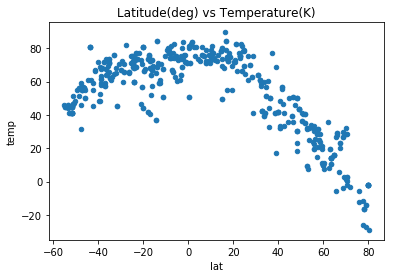

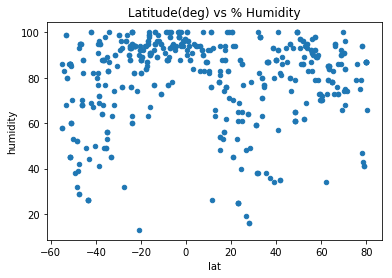

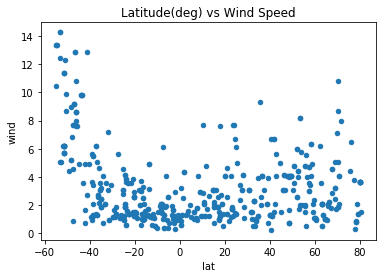

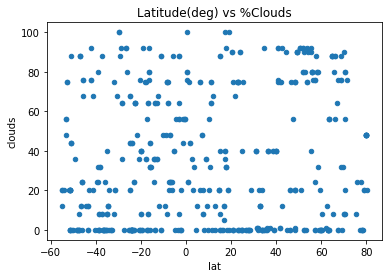

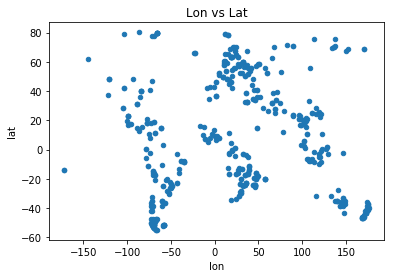

In [3]:
logger.info("Begin: Plot & Save Images")
import arff
weather_df = pd.read_pickle('../raw_data/weather_df.pkl')
weather500_df = weather_df.sample(SAMPLE_SIZE2,replace=True)
weather500_df.to_pickle('../raw_data/weather500_df.pkl')
weather500_df.to_csv("weather500_df.csv")
#
weather500_df.plot.scatter(x='lat',y='temp')
fig = plt.gcf()
plt.title("Latitude(deg) vs Temperature(K)")
plt.show()
fig.savefig("lat_temp.png")
logger.info("Image ")
#
weather500_df.plot.scatter(x='lat',y='humidity')
fig = plt.gcf()
plt.title("Latitude(deg) vs % Humidity")
plt.show()
fig.savefig("lat_humidity.png")
#
weather500_df.plot.scatter(x='lat',y='wind')
fig = plt.gcf()
plt.title("Latitude(deg) vs Wind Speed")
plt.show()
fig.savefig("lat_wind.png")
#
weather500_df.plot.scatter(x='lat',y='clouds')
fig = plt.gcf()
plt.title("Latitude(deg) vs %Clouds")
plt.show()
fig.savefig("lat_clouds.png")
#
weather500_df.plot.scatter(x='lon',y='lat')
fig = plt.gcf()
plt.title("Lon vs Lat")
plt.show()
fig.savefig("lon_lat.png")
logger.info("End: Plot & Save Images")



In [10]:
#Clean Log File
import re
with open("r_log.log","r") as f:
    data = f.read()
f.close()
ndata = re.sub(r'appid=\S+\s','appid=**hidden** ',data)
with open("r_log_clean.log","w") as f2:
    f2.write(ndata)
f2.close()